[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/marharyta-aleksandrova/conformal-learning/blob/main/tutorials/Exercise_3._Impact_of_nonconformity_functions_regression.ipynb)

Installing `nonconformist` library (uncomment the cells below)

In [1]:
# !git clone https://github.com/donlnz/nonconformist

In [2]:
# cd nonconformist

In [3]:
# !python setup.py install

# Imports

In [4]:
import numpy as np

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.datasets import load_iris, load_diabetes

from nonconformist.base import ClassifierAdapter, RegressorAdapter
from nonconformist.icp import IcpClassifier, IcpRegressor
from nonconformist.nc import MarginErrFunc
from nonconformist.nc import ClassifierNc, RegressorNc, RegressorNormalizer
from nonconformist.nc import AbsErrorErrFunc, SignErrorErrFunc

from nonconformist.evaluation import cross_val_score
from nonconformist.evaluation import ClassIcpCvHelper, RegIcpCvHelper
from nonconformist.evaluation import class_avg_c, class_mean_errors, class_one_c, class_one_err, \
    class_mean_errors_one_class, class_one_err_one_class, class_mean_p_val, class_empty, n_test
from nonconformist.evaluation import reg_mean_errors, reg_median_size, reg_min_size, reg_q1_size, reg_max_size
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

from nonconformist.nc import NcFactory

from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor

# Single run

## Point regression

Number of points  20000


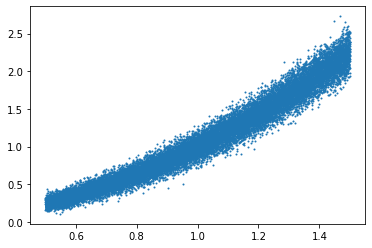

In [5]:
x = np.arange(0.5, 1.5 , 0.00005)
y = x**2 + np.random.normal(0, abs(0.1*x))
print('Number of points ', len(x))
x = x.reshape(-1, 1)
plt.scatter(x, y, s=1)

In [6]:
idx = np.random.permutation(len(y))
len_test = int(0.1 * len(y))
len_cal = int(0.2 * 0.9 * len(y))
print('Test: {}, calibration: {}, train: {}'.format(len_test, len_cal, len(y) - len_test - len_cal))

x_test, x_cal, x_train = x[idx[0:len_test]], x[idx[len_test:len_test+len_cal]], x[idx[len_test+len_cal:]]
y_test, y_cal, y_train = y[idx[0:len_test]], y[idx[len_test:len_test+len_cal]], y[idx[len_test+len_cal:]]

Test: 2000, calibration: 3600, train: 14400


In [7]:
model = RandomForestRegressor(n_estimators=100)
model = PolynomialFeatures(degree=2, include_bias=False)

In [8]:
train_features = model.fit_transform(x_train)
poly_reg_model = LinearRegression()
poly_reg_model.fit(train_features, y_train)
test_features = model.fit_transform(x_test)
y_predicted = poly_reg_model.predict(test_features)
tmp_df = pd.DataFrame({
    'x': x_test.T[0],
    'y': y_test,
    'y_p': y_predicted
})
tmp_df.sort_values(by='x', inplace=True)
#tmp_df

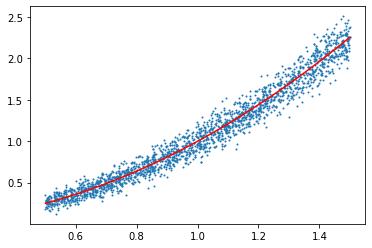

In [9]:
plt.scatter(tmp_df['x'], tmp_df['y'], s=1)
plt.plot(tmp_df['x'], tmp_df['y_p'], c='r')

## Conformal regression

In [10]:
nc = NcFactory.create_nc(poly_reg_model)

icp = IcpRegressor(nc)  # Create an inductive conformal regressor

# Fit the ICP using the proper training set
test_features = model.fit_transform(x_test)
icp.fit(test_features, y_test)

# Calibrate the ICP using the calibration set
cal_features = model.fit_transform(x_cal)
icp.calibrate(cal_features, y_cal)

# Produce predictions for the test set, with confidence 95%
test_features = model.fit_transform(x_test)
prediction = icp.predict(test_features, significance=0.05)
y_predicted = poly_reg_model.predict(test_features)

tmp_df = pd.DataFrame({
    'x': x_test.T[0],
    'y': y_test,
    'y_p': y_predicted,
    'low': prediction[:,0],
    'high': prediction[:,1],
})
tmp_df.sort_values(by='x', inplace=True)

acc = sum((tmp_df['y'] <= tmp_df['high']) & (tmp_df['y'] >= tmp_df['low'])) / len(tmp_df)

print('Accuracy = {}\n'.format(acc))

# Print the first 5 predictions
print(prediction[:5, :])

Accuracy = 0.9475

[[1.98870482 2.41477747]
 [0.47757254 0.9036452 ]
 [1.7391573  2.16522995]
 [0.22197744 0.64805009]
 [0.23380202 0.65987468]]


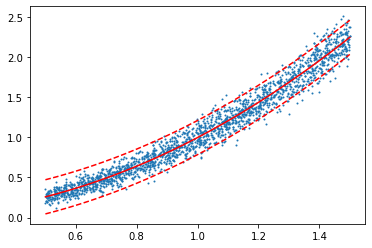

In [11]:
plt.scatter(tmp_df['x'], tmp_df['y'], s=1)
plt.plot(tmp_df['x'], tmp_df['y_p'], c='r')
plt.plot(tmp_df['x'], tmp_df['low'], '--', c='r')
plt.plot(tmp_df['x'], tmp_df['high'], '--', c='r')

## Normalized conformal regression

In [12]:
#nc = NcFactory.create_nc(poly_reg_model)

nc = NcFactory.create_nc(
    poly_reg_model,
    normalizer_model=KNeighborsRegressor(n_neighbors=11)
)

icp = IcpRegressor(nc)  # Create an inductive conformal regressor

# Fit the ICP using the proper training set
test_features = model.fit_transform(x_test)
icp.fit(test_features, y_test)

# Calibrate the ICP using the calibration set
cal_features = model.fit_transform(x_cal)
icp.calibrate(cal_features, y_cal)

# Produce predictions for the test set, with confidence 95%
test_features = model.fit_transform(x_test)
prediction = icp.predict(test_features, significance=0.05)
y_predicted = poly_reg_model.predict(test_features)

tmp_df = pd.DataFrame({
    'x': x_test.T[0],
    'y': y_test,
    'y_p': y_predicted,
    'low': prediction[:,0],
    'high': prediction[:,1],
})
tmp_df.sort_values(by='x', inplace=True)

acc = sum((tmp_df['y'] <= tmp_df['high']) & (tmp_df['y'] >= tmp_df['low'])) / len(tmp_df)

print('Accuracy = {}\n'.format(acc))


# Print the first 5 predictions
print(prediction[:5, :])

Accuracy = 0.9655

[[1.73526342 2.66821887]
 [0.54425804 0.8369597 ]
 [1.43882394 2.4655633 ]
 [0.26698824 0.60303928]
 [0.27340338 0.62027332]]


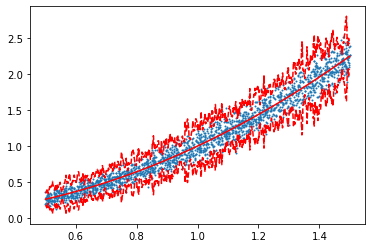

In [13]:
plt.scatter(tmp_df['x'], tmp_df['y'], s=1)
plt.plot(tmp_df['x'], tmp_df['y_p'], c='r')
plt.plot(tmp_df['x'], tmp_df['low'], '--', c='r')
plt.plot(tmp_df['x'], tmp_df['high'], '--', c='r')

Text(0, 0.5, 'size of the interval')

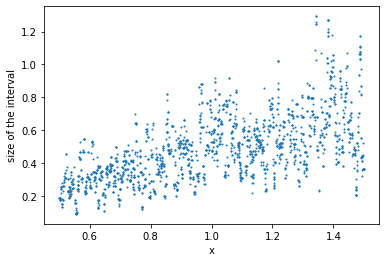

In [14]:
plt.scatter(tmp_df['x'], tmp_df['high'] - tmp_df['low'], s=1)
plt.xlabel('x')
plt.ylabel('size of the interval')

### Exercise

1. Use LinearRegression as `normalizer_model`. Which differences do you observe? Why?


# Cross-validation

In [15]:
data = load_diabetes()

In [16]:
from sklearn.datasets import fetch_california_housing

data = fetch_california_housing()#(as_frame=True)

In [17]:
len(data['target'])

20640

In [18]:
iterations = 1

## Absolute error

In [19]:
icp = IcpRegressor(RegressorNc(RegressorAdapter(RandomForestRegressor(n_estimators=100)),
                               AbsErrorErrFunc()))
icp_cv = RegIcpCvHelper(icp)

scores = cross_val_score(icp_cv,
                         data.data,
                         data.target,
                         iterations=iterations,
                         folds=5,
                         scoring_funcs=[
                             reg_mean_errors,
                             reg_median_size,
                             reg_min_size,
                             reg_q1_size,
                             reg_max_size,
                         ],
                         significance_levels=[0.05, 0.1, 0.2],
                         verbose=True)

print('Absolute error regression: diabetes')
scores = scores.drop(['fold', 'iter'], axis=1)
scores_AE = scores.groupby(['significance']).mean()
scores_AE

iter 1/1 fold 5/5Absolute error regression: diabetes


,reg_mean_errors,reg_median_size,reg_min_size,reg_q1_size,reg_max_size
significance,,,,,
0.05,0.050436,2.183613,2.183613,2.183613,2.183613
0.10,0.101260,1.562681,1.562681,1.562681,1.562681
0.20,0.201260,1.035565,1.035565,1.035565,1.035565


## Normalized absolute error

In [20]:
underlying_model = RegressorAdapter(RandomForestRegressor(n_estimators=100))
normalizer_model = RegressorAdapter(RandomForestRegressor(n_estimators=100))
normalizer = RegressorNormalizer(underlying_model, normalizer_model, AbsErrorErrFunc())
nc = RegressorNc(underlying_model, AbsErrorErrFunc(), normalizer)

icp = IcpRegressor(nc)
icp_cv = RegIcpCvHelper(icp)

scores = cross_val_score(icp_cv,
                         data.data,
                         data.target,
                         iterations=iterations,
                         folds=5,
                         scoring_funcs=[
                             reg_mean_errors,
                             reg_median_size,
                             reg_min_size,
                             reg_q1_size,
                             reg_max_size,
                         ],
                         significance_levels=[0.05, 0.1, 0.2])

print('Normalized absolute error regression: diabetes')
scores = scores.drop(['fold', 'iter'], axis=1)
scores_NAE = scores.groupby(['significance']).mean()
scores_NAE

Normalized absolute error regression: diabetes


,reg_mean_errors,reg_median_size,reg_min_size,reg_q1_size,reg_max_size
significance,,,,,
0.05,0.049903,1.701807,0.000307,1.092758,10.058816
0.10,0.098256,1.264119,0.000228,0.811978,7.483659
0.20,0.198789,0.889256,0.000160,0.571319,5.269989


## Signed Error

In [21]:
icp = IcpRegressor(RegressorNc(RegressorAdapter(RandomForestRegressor(n_estimators=100)),
                               SignErrorErrFunc()))
icp_cv = RegIcpCvHelper(icp)

scores = cross_val_score(icp_cv,
                         data.data,
                         data.target,
                         iterations=iterations,
                         folds=5,
                         scoring_funcs=[
                             reg_mean_errors,
                             reg_median_size,
                             reg_min_size,
                             reg_q1_size,
                             reg_max_size,
                         ],
                         significance_levels=[0.05, 0.1, 0.2])

print('Signed error regression: diabetes')
scores = scores.drop(['fold', 'iter'], axis=1)
scores_SE = scores.groupby(['significance']).mean()
scores_SE

Signed error regression: diabetes


,reg_mean_errors,reg_median_size,reg_min_size,reg_q1_size,reg_max_size
significance,,,,,
0.05,0.035562,2.544475,2.544475,2.544475,2.544475
0.10,0.081008,1.753548,1.753548,1.753548,1.753548
0.20,0.189050,1.073118,1.073118,1.073118,1.073118


## Normalized signed error

In [22]:
underlying_model = RegressorAdapter(RandomForestRegressor(n_estimators=100))
normalizer_model = RegressorAdapter(RandomForestRegressor(n_estimators=100))

# The normalization model can use a different error function than is
# used to measure errors on the underlying model
normalizer = RegressorNormalizer(underlying_model, normalizer_model, AbsErrorErrFunc())
nc = RegressorNc(underlying_model, SignErrorErrFunc(), normalizer)

icp = IcpRegressor(nc)
icp_cv = RegIcpCvHelper(icp)

scores = cross_val_score(icp_cv,
                         data.data,
                         data.target,
                         iterations=iterations,
                         folds=5,
                         scoring_funcs=[
                             reg_mean_errors,
                             reg_median_size,
                             reg_min_size,
                             reg_q1_size,
                             reg_max_size,
                         ],
                         significance_levels=[0.05, 0.1, 0.2])

print('Normalized signed error regression: diabetes')
scores = scores.drop(['fold', 'iter'], axis=1)
scores_NSE = scores.groupby(['significance']).mean()
scores_NSE

Normalized signed error regression: diabetes


,reg_mean_errors,reg_median_size,reg_min_size,reg_q1_size,reg_max_size
significance,,,,,
0.05,0.033285,2.031826,0.000404,1.324588,12.444457
0.10,0.077083,1.393032,0.000276,0.907807,8.540996
0.20,0.189680,0.904063,0.000180,0.589339,5.552158


## Analysis

### Validity

In [23]:
col = 'reg_mean_errors'
tmp = pd.DataFrame({
    'AE': scores_AE[col],
    'NAE': scores_NAE[col],
    'SE': scores_SE[col],
    'NSE': scores_NSE[col],
})
tmp

,AE,NAE,SE,NSE
significance,,,,
0.05,0.050436,0.049903,0.035562,0.033285
0.10,0.101260,0.098256,0.081008,0.077083
0.20,0.201260,0.198789,0.189050,0.189680


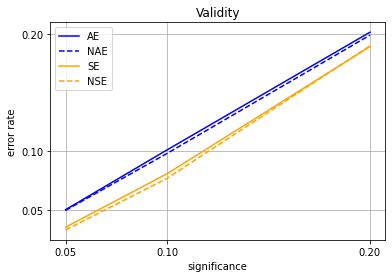

In [24]:
plt.plot(tmp.index, tmp['AE'], c='b')
plt.plot(tmp.index, tmp['NAE'], '--', c='b')
plt.plot(tmp.index, tmp['SE'], c='orange')
plt.plot(tmp.index, tmp['NSE'], '--', c='orange')

plt.xticks(tmp.index)
plt.yticks(tmp.index)
plt.legend(['AE', 'NAE', 'SE', 'NSE'] )
plt.title('Validity')
plt.xlabel('significance')
plt.ylabel('error rate')
plt.grid(True)

### Efficiency

Median size

In [25]:
col = 'reg_median_size'
tmp = pd.DataFrame({
    'AE': scores_AE[col],
    'NAE': scores_NAE[col],
    'SE': scores_SE[col],
    'NSE': scores_NSE[col],
})
tmp

,AE,NAE,SE,NSE
significance,,,,
0.05,2.183613,1.701807,2.544475,2.031826
0.10,1.562681,1.264119,1.753548,1.393032
0.20,1.035565,0.889256,1.073118,0.904063


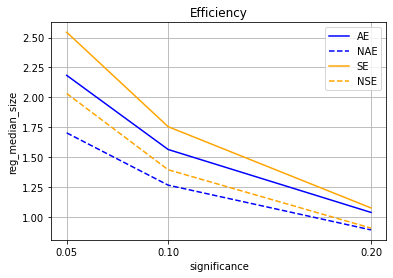

In [26]:
plt.plot(tmp.index, tmp['AE'], c='b')
plt.plot(tmp.index, tmp['NAE'], '--', c='b')
plt.plot(tmp.index, tmp['SE'], c='orange')
plt.plot(tmp.index, tmp['NSE'], '--', c='orange')

plt.xticks(tmp.index)
plt.legend(['AE', 'NAE', 'SE', 'NSE'] )
plt.title('Efficiency')
plt.xlabel('significance')
plt.ylabel('{}'.format(col))
plt.grid(True)

Min size

In [27]:
col = 'reg_min_size'
tmp = pd.DataFrame({
    'AE': scores_AE[col],
    'NAE': scores_NAE[col],
    'SE': scores_SE[col],
    'NSE': scores_NSE[col],
})
tmp

,AE,NAE,SE,NSE
significance,,,,
0.05,2.183613,0.000307,2.544475,0.000404
0.10,1.562681,0.000228,1.753548,0.000276
0.20,1.035565,0.000160,1.073118,0.000180


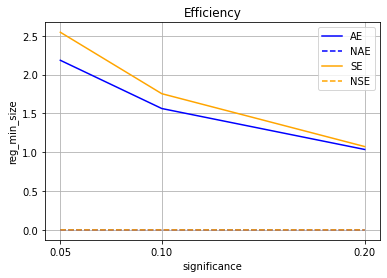

In [28]:
plt.plot(tmp.index, tmp['AE'], c='b')
plt.plot(tmp.index, tmp['NAE'], '--', c='b')
plt.plot(tmp.index, tmp['SE'], c='orange')
plt.plot(tmp.index, tmp['NSE'], '--', c='orange')

plt.xticks(tmp.index)
plt.legend(['AE', 'NAE', 'SE', 'NSE'] )
plt.title('Efficiency')
plt.xlabel('significance')
plt.ylabel('{}'.format(col))
plt.grid(True)

Max size

In [29]:
col = 'reg_max_size'
tmp = pd.DataFrame({
    'AE': scores_AE[col],
    'NAE': scores_NAE[col],
    'SE': scores_SE[col],
    'NSE': scores_NSE[col],
})
tmp

,AE,NAE,SE,NSE
significance,,,,
0.05,2.183613,10.058816,2.544475,12.444457
0.10,1.562681,7.483659,1.753548,8.540996
0.20,1.035565,5.269989,1.073118,5.552158


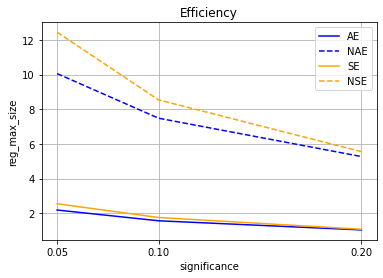

In [30]:
plt.plot(tmp.index, tmp['AE'], c='b')
plt.plot(tmp.index, tmp['NAE'], '--', c='b')
plt.plot(tmp.index, tmp['SE'], c='orange')
plt.plot(tmp.index, tmp['NSE'], '--', c='orange')

plt.xticks(tmp.index)
plt.legend(['AE', 'NAE', 'SE', 'NSE'] )
plt.title('Efficiency')
plt.xlabel('significance')
plt.ylabel('{}'.format(col))
plt.grid(True)

Try with different regression models & different datasets.